In [14]:
import pandas as pd
import math
import statistics
import os
from tqdm import tqdm_notebook
from sklearn.impute import KNNImputer
import impyute as impy
import time
from termcolor import colored, cprint
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('nfl_data.csv')

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (25,51) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def ranking(dict_list, columns):
    accuracy_ranking = {}
    speed_ranking = {}
    for x in columns:
        accuracy = []
        speed = []
        for y in dict_list:
            accuracy.append((dict_list[y][x][0], y))
            speed.append((dict_list[y][x][1], y))
        accuracy.sort()
        accuracy = [(accuracy[y][0], accuracy[y][1], (y + 1)) for y in range(len(accuracy))]
        speed.sort()
        speed = [(speed[y][0], speed[y][1], (y + 1)) for y in range(len(speed))]
        accuracy_ranking[x] = accuracy
        speed_ranking[x] = speed
    return accuracy_ranking, speed_ranking
            

In [4]:
def imputation_ranker(dataframe, pref=None, maxmis=0.66, sample=0.01, misper=0.3):
    # Drop columns without enough data
    rank_print = lambda x : cprint(x, 'red')
    dataframe = df.copy()
    dropped_columns = []
    for column in dataframe.columns:
        if len(dataframe[dataframe[column].isna()]) > len(dataframe) * maxmis:
            dropped_columns.append(column)
            dataframe = dataframe.drop(columns=column)
    rank_print("The following columns did not meet the minimum amount of needed data and have therefore been dropped: ")
    print(dropped_columns)
    print('\n')
    
    #Create subset of data with and without NaN
    test = dataframe.dropna().sample(int(len(dataframe) * sample), random_state=0).reset_index(drop=True)
    nantest = test.copy()
    for column in nantest.columns:
        change = nantest.sample(int(len(test) * misper)).index
        nantest.loc[change, column] = None
    
    rank_print('The constructed test dataset contains ' + str(len(test)) + ' rows, from which each columns has ' + str(int(len(test) * misper)) + ' rows missing.')
    print('\n')
    # Initialize storages
    number_columns = [column for column in test.columns if test[column].dtype in [float, int, 'int64', 'float64']]
    
    rank_print("The following " + str(len(number_columns)) + " columns will be tested: ")
    print(number_columns)
    print('\n')
    # KNN imputation
    imputer = KNNImputer()
    start_time = time.time()
    knn_imputed = imputer.fit_transform(nantest[number_columns])
    knn_imputed = pd.DataFrame(knn_imputed, columns=number_columns)
    endtime = (time.time() - start_time) / len(number_columns)
    knn = {}
    for column in number_columns:
        diff = [abs(test[column][x] - knn_imputed[column][x]) for x in change]
        knn[column] = [statistics.mean(diff), endtime]
    rank_print('KNN done')
    
    # MICE imputation
    start_time = time.time()
    mice_imputed = impy.mice(nantest[number_columns].to_numpy())
    mice_imputed = pd.DataFrame(mice_imputed, columns=number_columns)
    endtime = (time.time() - start_time) / len(number_columns)
    mice = {}
    for column in number_columns:
        diff = [abs(test[column][x] - mice_imputed[column][x]) for x in change]
        mice[column] = [statistics.mean(diff), endtime]
    rank_print("MICE done")
    
    # Mean imputation
    mean_imputed = nantest.fillna(nantest.mean())
    mean = {}
    for column in number_columns:
        start_time = time.time()
        diff = [abs(test[column][x] - mean_imputed[column][x]) for x in change]
        mean[column] = [statistics.mean(diff), time.time() - start_time]
    rank_print('Mean done')
    
    # Mode imputation
    mode_num_imp = nantest[number_columns].fillna(nantest.mode().iloc[0])
    mode_num = {}
    for column in number_columns:
        start_time = time.time()
        diff = [abs(test[column][x] - mode_num_imp[column][x]) for x in change]
        mode_num[column] = [statistics.mean(diff), time.time() - start_time]
    rank_print("Mode done")
    
    # Rank imputation methods
    dict_dict = {'mode': mode_num, 'mean': mean, 'knn': knn, 'mice': mice}
    accuracy_ranking, speed_ranking = ranking(dict_dict, number_columns)
    final_ranking = {}
    if pref == None:
        for x in number_columns:
            knn_score = 0
            mice_score = 0
            mean_score = 0
            mode_score = 0
            for y in range(len(accuracy_ranking[x])):
                if accuracy_ranking[x][y][1] == 'mode':
                    mode_score += accuracy_ranking[x][y][2]
                elif accuracy_ranking[x][y][1] == 'mean':
                    mean_score += accuracy_ranking[x][y][2]
                elif accuracy_ranking[x][y][1] == 'knn':
                    knn_score += accuracy_ranking[x][y][2]
                elif accuracy_ranking[x][y][1] == 'mice':
                    mice_score += accuracy_ranking[x][y][2]
                    
            for y in range(len(speed_ranking[x])):
                if speed_ranking[x][y][1] == 'mode':
                    mode_score += accuracy_ranking[x][y][2]
                elif speed_ranking[x][y][1] == 'mean':
                    mean_score += accuracy_ranking[x][y][2]
                elif speed_ranking[x][y][1] == 'knn':
                    knn_score += accuracy_ranking[x][y][2]
                elif speed_ranking[x][y][1] == 'mice':
                    mice_score += accuracy_ranking[x][y][2]
            final_score = [(mode_score, 'mode'), (mean_score, 'mean'), (knn_score, 'knn'), (mice_score, 'mice')]
            final_score.sort()
            final_ranking[x] = final_score
            
    elif pref == 'speed':
        for x in number_columns:
            knn_score = 0
            mice_score = 0
            mean_score = 0
            mode_score = 0
            for y in range(len(accuracy_ranking[x])):
                if accuracy_ranking[x][y][1] == 'mode':
                    mode_score += accuracy_ranking[x][y][2]
                elif accuracy_ranking[x][y][1] == 'mean':
                    mean_score += accuracy_ranking[x][y][2]
                elif accuracy_ranking[x][y][1] == 'knn':
                    knn_score += accuracy_ranking[x][y][2]
                elif accuracy_ranking[x][y][1] == 'mice':
                    mice_score += accuracy_ranking[x][y][2]
                    
            for y in range(len(speed_ranking[x])):
                if speed_ranking[x][y][1] == 'mode':
                    mode_score += accuracy_ranking[x][y][2] * 2
                elif speed_ranking[x][y][1] == 'mean':
                    mean_score += accuracy_ranking[x][y][2] * 2
                elif speed_ranking[x][y][1] == 'knn':
                    knn_score += accuracy_ranking[x][y][2] * 2
                elif speed_ranking[x][y][1] == 'mice':
                    mice_score += accuracy_ranking[x][y][2] * 2
            final_score = [(mode_score, 'mode'), (mean_score, 'mean'), (knn_score, 'knn'), (mice_score, 'mice')]
            final_score.sort()
            final_ranking[x] = final_score
    
    elif pref == 'accuracy':
        for x in number_columns:
            knn_score = 0
            mice_score = 0
            mean_score = 0
            mode_score = 0
            for y in range(len(accuracy_ranking[x])):
                if accuracy_ranking[x][y][1] == 'mode':
                    mode_score += accuracy_ranking[x][y][2] * 2
                elif accuracy_ranking[x][y][1] == 'mean':
                    mean_score += accuracy_ranking[x][y][2] * 2
                elif accuracy_ranking[x][y][1] == 'knn':
                    knn_score += accuracy_ranking[x][y][2] * 2
                elif accuracy_ranking[x][y][1] == 'mice':
                    mice_score += accuracy_ranking[x][y][2] * 2
                    
            for y in range(len(speed_ranking[x])):
                if speed_ranking[x][y][1] == 'mode':
                    mode_score += accuracy_ranking[x][y][2]
                elif speed_ranking[x][y][1] == 'mean':
                    mean_score += accuracy_ranking[x][y][2]
                elif speed_ranking[x][y][1] == 'knn':
                    knn_score += accuracy_ranking[x][y][2]
                elif speed_ranking[x][y][1] == 'mice':
                    mice_score += accuracy_ranking[x][y][2]
            final_score = [(mode_score, 'mode'), (mean_score, 'mean'), (knn_score, 'knn'), (mice_score, 'mice')]
            final_score.sort()
            final_ranking[x] = final_score
    
    # Give final overall ranking
    final_mean = 0
    final_mode = 0
    final_mice = 0
    final_knn = 0
    for x in final_ranking:
        if final_ranking[x][0][1] == 'mode':
            final_mode += 1
        elif final_ranking[x][0][1] == 'mean':
            final_mean += 1
        elif final_ranking[x][0][1] == 'knn':
            final_knn += 1
        elif final_ranking[x][0][1] == 'mice':
            final_mice += 1
    final = [(final_mean, 'mean'), (final_mode, 'mode'), (final_knn, 'knn'), (final_mice, 'mice')]
    final.sort(reverse=True)
    rank_print("Final overall ranking:")
    rank_print('1. ' + final[0][1])
    rank_print('2. ' + final[1][1])
    rank_print('3. ' + final[2][1])
    rank_print('4. ' + final[3][1])
        
    return final_ranking

In [32]:
# Default
start_time = time.time()
default = imputation_ranker(df, pref=None, maxmis=0.66, sample=0.01, misper=0.3)
time.time() - start_time

The following columns did not meet the minimum amount of needed data and have therefore been dropped: 
['ExPointResult', 'TwoPointConv', 'DefTwoPoint', 'PuntResult', 'Interceptor', 'Rusher', 'RunLocation', 'RunGap', 'ReturnResult', 'Returner', 'BlockingPlayer', 'Tackler2', 'FieldGoalResult', 'FieldGoalDistance', 'RecFumbTeam', 'RecFumbPlayer', 'ChalReplayResult', 'PenalizedTeam', 'PenaltyType', 'PenalizedPlayer']


The constructed test dataset contains 3624 rows, from which each columns has 1087 rows missing.


The following 63 columns will be tested: 
['GameID', 'Drive', 'qtr', 'down', 'TimeUnder', 'TimeSecs', 'PlayTimeDiff', 'yrdln', 'yrdline100', 'ydstogo', 'ydsnet', 'GoalToGo', 'FirstDown', 'PlayAttempted', 'Yards.Gained', 'sp', 'Touchdown', 'Safety', 'Onsidekick', 'PassAttempt', 'AirYards', 'YardsAfterCatch', 'QBHit', 'InterceptionThrown', 'RushAttempt', 'Reception', 'Fumble', 'Sack', 'Challenge.Replay', 'Accepted.Penalty', 'Penalty.Yards', 'PosTeamScore', 'DefTeamScore', 'ScoreDi

116.16136813163757

In [33]:
final_mean = 0
final_mode = 0
final_mice = 0
final_knn = 0
for x in default:
    if default[x][0][1] == 'mode':
        final_mode += 1
    elif default[x][0][1] == 'mean':
        final_mean += 1
    elif default[x][0][1] == 'knn':
        final_knn += 1
    elif default[x][0][1] == 'mice':
        final_mice += 1
final_default = [(final_mean, 'mean'), (final_mode, 'mode'), (final_knn, 'knn'), (final_mice, 'mice')]
del default

In [34]:
# More missing
start_time = time.time()
more_missing = imputation_ranker(df, pref=None, maxmis=0.66, sample=0.01, misper=0.5)
time.time() - start_time

The following columns did not meet the minimum amount of needed data and have therefore been dropped: 
['ExPointResult', 'TwoPointConv', 'DefTwoPoint', 'PuntResult', 'Interceptor', 'Rusher', 'RunLocation', 'RunGap', 'ReturnResult', 'Returner', 'BlockingPlayer', 'Tackler2', 'FieldGoalResult', 'FieldGoalDistance', 'RecFumbTeam', 'RecFumbPlayer', 'ChalReplayResult', 'PenalizedTeam', 'PenaltyType', 'PenalizedPlayer']


The constructed test dataset contains 3624 rows, from which each columns has 1812 rows missing.


The following 63 columns will be tested: 
['GameID', 'Drive', 'qtr', 'down', 'TimeUnder', 'TimeSecs', 'PlayTimeDiff', 'yrdln', 'yrdline100', 'ydstogo', 'ydsnet', 'GoalToGo', 'FirstDown', 'PlayAttempted', 'Yards.Gained', 'sp', 'Touchdown', 'Safety', 'Onsidekick', 'PassAttempt', 'AirYards', 'YardsAfterCatch', 'QBHit', 'InterceptionThrown', 'RushAttempt', 'Reception', 'Fumble', 'Sack', 'Challenge.Replay', 'Accepted.Penalty', 'Penalty.Yards', 'PosTeamScore', 'DefTeamScore', 'ScoreDi

160.26375365257263

In [35]:
final_mean = 0
final_mode = 0
final_mice = 0
final_knn = 0
for x in more_missing:
    if more_missing[x][0][1] == 'mode':
        final_mode += 1
    elif more_missing[x][0][1] == 'mean':
        final_mean += 1
    elif more_missing[x][0][1] == 'knn':
        final_knn += 1
    elif more_missing[x][0][1] == 'mice':
        final_mice += 1
final_more_missing = [(final_mean, 'mean'), (final_mode, 'mode'), (final_knn, 'knn'), (final_mice, 'mice')]
del more_missing

In [36]:
# Less missing
start_time = time.time()
less_missing = imputation_ranker(df, pref=None, maxmis=0.66, sample=0.01, misper=0.1)
time.time() - start_time

The following columns did not meet the minimum amount of needed data and have therefore been dropped: 
['ExPointResult', 'TwoPointConv', 'DefTwoPoint', 'PuntResult', 'Interceptor', 'Rusher', 'RunLocation', 'RunGap', 'ReturnResult', 'Returner', 'BlockingPlayer', 'Tackler2', 'FieldGoalResult', 'FieldGoalDistance', 'RecFumbTeam', 'RecFumbPlayer', 'ChalReplayResult', 'PenalizedTeam', 'PenaltyType', 'PenalizedPlayer']


The constructed test dataset contains 3624 rows, from which each columns has 362 rows missing.


The following 63 columns will be tested: 
['GameID', 'Drive', 'qtr', 'down', 'TimeUnder', 'TimeSecs', 'PlayTimeDiff', 'yrdln', 'yrdline100', 'ydstogo', 'ydsnet', 'GoalToGo', 'FirstDown', 'PlayAttempted', 'Yards.Gained', 'sp', 'Touchdown', 'Safety', 'Onsidekick', 'PassAttempt', 'AirYards', 'YardsAfterCatch', 'QBHit', 'InterceptionThrown', 'RushAttempt', 'Reception', 'Fumble', 'Sack', 'Challenge.Replay', 'Accepted.Penalty', 'Penalty.Yards', 'PosTeamScore', 'DefTeamScore', 'ScoreDif

3348.045892715454

In [37]:
final_mean = 0
final_mode = 0
final_mice = 0
final_knn = 0
for x in less_missing:
    if less_missing[x][0][1] == 'mode':
        final_mode += 1
    elif less_missing[x][0][1] == 'mean':
        final_mean += 1
    elif less_missing[x][0][1] == 'knn':
        final_knn += 1
    elif less_missing[x][0][1] == 'mice':
        final_mice += 1
final_less_missing = [(final_mean, 'mean'), (final_mode, 'mode'), (final_knn, 'knn'), (final_mice, 'mice')]
del less_missing

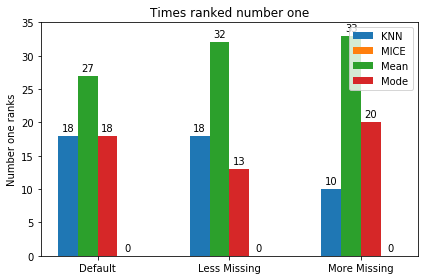

In [38]:
labels = ['Default', 'Less Missing', "More Missing"]
knn_score = [final_default[2][0], final_less_missing[2][0], final_more_missing[2][0]]
mice_score = [final_default[3][0], final_less_missing[3][0], final_more_missing[3][0]]
mean_score = [final_default[0][0], final_less_missing[0][0], final_more_missing[0][0]]
mode_score = [final_default[1][0], final_less_missing[1][0], final_more_missing[1][0]]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width*1.5, knn_score, width, label='KNN')
rects2 = ax.bar(x + width*1.5, mice_score, width, label='MICE')
rects3 = ax.bar(x - width/2, mean_score, width, label='Mean')
rects4 = ax.bar(x + width/2, mode_score, width, label='Mode')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number one ranks')
ax.set_title('Times ranked number one')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 35) 


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
fig.tight_layout()
plt.savefig('default_missing')
plt.show()

In [39]:
# More Sample
start_time = time.time()
more_sample = imputation_ranker(df, pref=None, maxmis=0.66, sample=0.05, misper=0.3)
time.time() - start_time

The following columns did not meet the minimum amount of needed data and have therefore been dropped: 
['ExPointResult', 'TwoPointConv', 'DefTwoPoint', 'PuntResult', 'Interceptor', 'Rusher', 'RunLocation', 'RunGap', 'ReturnResult', 'Returner', 'BlockingPlayer', 'Tackler2', 'FieldGoalResult', 'FieldGoalDistance', 'RecFumbTeam', 'RecFumbPlayer', 'ChalReplayResult', 'PenalizedTeam', 'PenaltyType', 'PenalizedPlayer']


The constructed test dataset contains 18122 rows, from which each columns has 5436 rows missing.


The following 63 columns will be tested: 
['GameID', 'Drive', 'qtr', 'down', 'TimeUnder', 'TimeSecs', 'PlayTimeDiff', 'yrdln', 'yrdline100', 'ydstogo', 'ydsnet', 'GoalToGo', 'FirstDown', 'PlayAttempted', 'Yards.Gained', 'sp', 'Touchdown', 'Safety', 'Onsidekick', 'PassAttempt', 'AirYards', 'YardsAfterCatch', 'QBHit', 'InterceptionThrown', 'RushAttempt', 'Reception', 'Fumble', 'Sack', 'Challenge.Replay', 'Accepted.Penalty', 'Penalty.Yards', 'PosTeamScore', 'DefTeamScore', 'ScoreD

1901.1049711704254

In [40]:
final_mean = 0
final_mode = 0
final_mice = 0
final_knn = 0
for x in more_sample:
    if more_sample[x][0][1] == 'mode':
        final_mode += 1
    elif more_sample[x][0][1] == 'mean':
        final_mean += 1
    elif more_sample[x][0][1] == 'knn':
        final_knn += 1
    elif more_sample[x][0][1] == 'mice':
        final_mice += 1
final_more_sample = [(final_mean, 'mean'), (final_mode, 'mode'), (final_knn, 'knn'), (final_mice, 'mice')]
del more_sample

In [41]:
# Less Sample
start_time = time.time()
less_sample = imputation_ranker(df, pref=None, maxmis=0.66, sample=0.005, misper=0.3)
time.time() - start_time

The following columns did not meet the minimum amount of needed data and have therefore been dropped: 
['ExPointResult', 'TwoPointConv', 'DefTwoPoint', 'PuntResult', 'Interceptor', 'Rusher', 'RunLocation', 'RunGap', 'ReturnResult', 'Returner', 'BlockingPlayer', 'Tackler2', 'FieldGoalResult', 'FieldGoalDistance', 'RecFumbTeam', 'RecFumbPlayer', 'ChalReplayResult', 'PenalizedTeam', 'PenaltyType', 'PenalizedPlayer']


The constructed test dataset contains 1812 rows, from which each columns has 543 rows missing.


The following 63 columns will be tested: 
['GameID', 'Drive', 'qtr', 'down', 'TimeUnder', 'TimeSecs', 'PlayTimeDiff', 'yrdln', 'yrdline100', 'ydstogo', 'ydsnet', 'GoalToGo', 'FirstDown', 'PlayAttempted', 'Yards.Gained', 'sp', 'Touchdown', 'Safety', 'Onsidekick', 'PassAttempt', 'AirYards', 'YardsAfterCatch', 'QBHit', 'InterceptionThrown', 'RushAttempt', 'Reception', 'Fumble', 'Sack', 'Challenge.Replay', 'Accepted.Penalty', 'Penalty.Yards', 'PosTeamScore', 'DefTeamScore', 'ScoreDif

47.96737360954285

In [42]:
final_mean = 0
final_mode = 0
final_mice = 0
final_knn = 0
for x in less_sample:
    if less_sample[x][0][1] == 'mode':
        final_mode += 1
    elif less_sample[x][0][1] == 'mean':
        final_mean += 1
    elif less_sample[x][0][1] == 'knn':
        final_knn += 1
    elif less_sample[x][0][1] == 'mice':
        final_mice += 1
final_less_sample = [(final_mean, 'mean'), (final_mode, 'mode'), (final_knn, 'knn'), (final_mice, 'mice')]
del less_sample

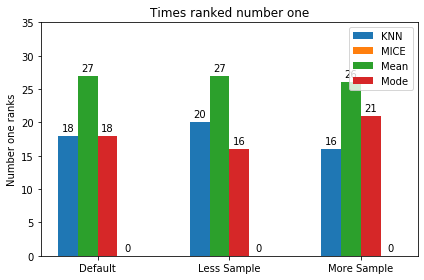

In [43]:
labels = ['Default', 'Less Sample', "More Sample"]
knn_score = [final_default[2][0], final_less_sample[2][0], final_more_sample[2][0]]
mice_score = [final_default[3][0], final_less_sample[3][0], final_more_sample[3][0]]
mean_score = [final_default[0][0], final_less_sample[0][0], final_more_sample[0][0]]
mode_score = [final_default[1][0], final_less_sample[1][0], final_more_sample[1][0]]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width*1.5, knn_score, width, label='KNN')
rects2 = ax.bar(x + width*1.5, mice_score, width, label='MICE')
rects3 = ax.bar(x - width/2, mean_score, width, label='Mean')
rects4 = ax.bar(x + width/2, mode_score, width, label='Mode')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number one ranks')
ax.set_title('Times ranked number one')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 35) 


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
fig.tight_layout()
plt.savefig('default_sample')
plt.show()